In [1]:
!pip install openpyxl
!pip install xgboost
!pip install tensorflow==2.12.0

In [2]:
from google.colab import drive

import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from keras.layers import ConvLSTM2D, Dense, Flatten
from sklearn.ensemble import GradientBoostingRegressor

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
data = '/content/drive/My Drive/Tinggi Muka Air.xlsx'

In [5]:
df = pd.read_excel(data)

# Menghitung jumlah data dalam dataset
jumlah_data = len(df)

# Menampilkan jumlah data
print(f"Jumlah data dalam dataset: {jumlah_data}")

Jumlah data dalam dataset: 2190


In [6]:
df.head()

,Bulan Tahun,Tinggi Bendungan
0,2012-01-01,57.740
1,2012-01-02,57.860
2,2012-01-03,57.925
3,2012-01-04,57.945
4,2012-01-05,57.940


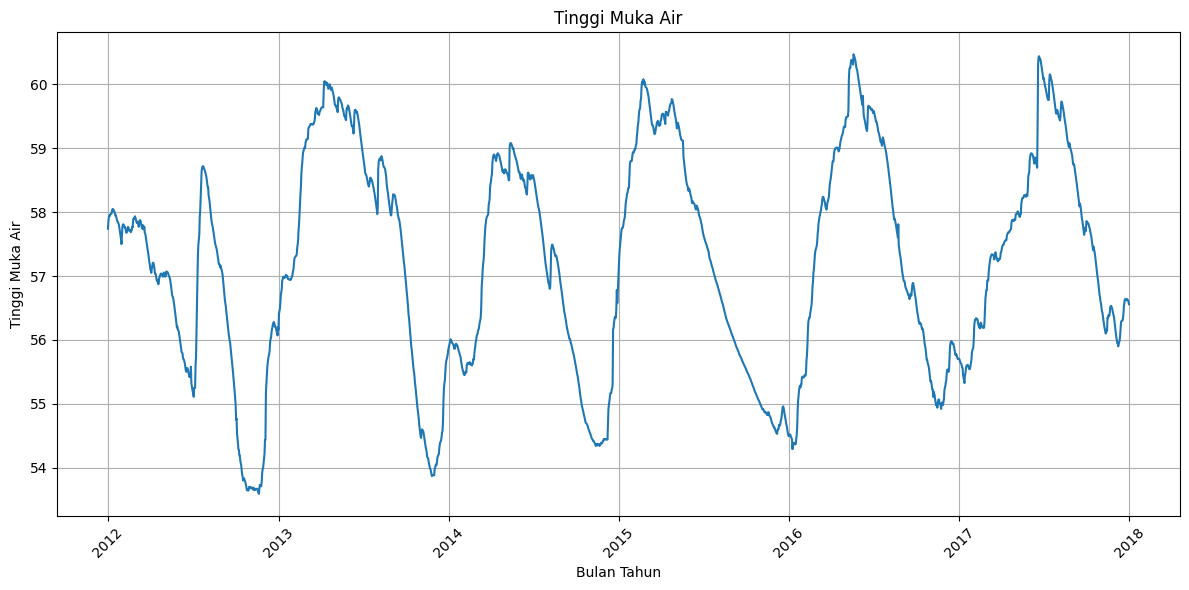

In [7]:
# Buat plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Bulan Tahun', y='Tinggi Bendungan')
plt.title('Tinggi Muka Air')
plt.xlabel('Bulan Tahun')
plt.ylabel('Tinggi Muka Air')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Membaca dataset
df = pd.read_excel(data)

# Mengatur 'Bulan_Tahun' sebagai indeks
df.set_index('Bulan Tahun', inplace=True)
df.index = pd.to_datetime(df.index, format='%Y-%m')

# Scaling data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Split data menjadi train dan test set
train_size = int(len(df_scaled) * 0.6)
test_size = len(df_scaled) - train_size
train, test = df_scaled[0:train_size,:], df_scaled[train_size:len(df_scaled),:]

# Fungsi untuk membuat dataset dengan timesteps
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps - 1):
        a = dataset[i:(i + time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

# Menyiapkan data untuk ConvLSTM
time_steps = 84  # misalnya, menggunakan data 84 bulan sebelumnya untuk memprediksi bulan berikutnya
X_train_conv, y_train_conv = create_dataset(train, time_steps)
X_test_conv, y_test_conv = create_dataset(test, time_steps)

# Reshape data ke [samples, time_steps, rows, cols, features]
X_train_conv = np.reshape(X_train_conv, (X_train_conv.shape[0], X_train_conv.shape[1], 1, 1, 1))
X_test_conv = np.reshape(X_test_conv, (X_test_conv.shape[0], X_test_conv.shape[1], 1, 1, 1))

# Membangun model ConvLSTM
model_conv = Sequential([
    ConvLSTM2D(32, (1, 1), input_shape=(time_steps, 1, 1, 1)),
    Flatten(),
    Dense(1)
])
model_conv.compile(optimizer='adam', loss='mean_squared_error')

# Menambahkan Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Melatih model
history_conv = model_conv.fit(X_train_conv, y_train_conv, epochs=500, batch_size=32, verbose=1, validation_split=0.6, callbacks=[early_stop])

# Prediksi data test
predicted_conv = model_conv.predict(X_test_conv)

# Mengembalikan skala data ke bentuk semula
predicted_conv = scaler.inverse_transform(predicted_conv)
y_test_conv = scaler.inverse_transform([y_test_conv])

# Menghitung RMSE untuk ConvLSTM
rmse_conv = np.sqrt(mean_squared_error(y_test_conv[0], predicted_conv[:,0]))
print(f"Root Mean Squared Error (ConvLSTM): {rmse_conv:.4f}")

Epoch 1/500
16/16 [==============================] - 4s 115ms/step - loss: 0.1319 - val_loss: 0.0092
Epoch 2/500
16/16 [==============================] - 1s 68ms/step - loss: 0.0138 - val_loss: 0.0056
Epoch 3/500
16/16 [==============================] - 1s 73ms/step - loss: 0.0073 - val_loss: 0.0046
Epoch 4/500
16/16 [==============================] - 1s 76ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 5/500
16/16 [==============================] - 1s 71ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 6/500
16/16 [==============================] - 1s 73ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 7/500
16/16 [==============================] - 1s 69ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 8/500
16/16 [==============================] - 1s 70ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 9/500
16/16 [==============================] - 1s 72ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 10/500
16/16 [==============================] - 1s 72ms/step - loss: 0.0026 - val_loss: 0.001

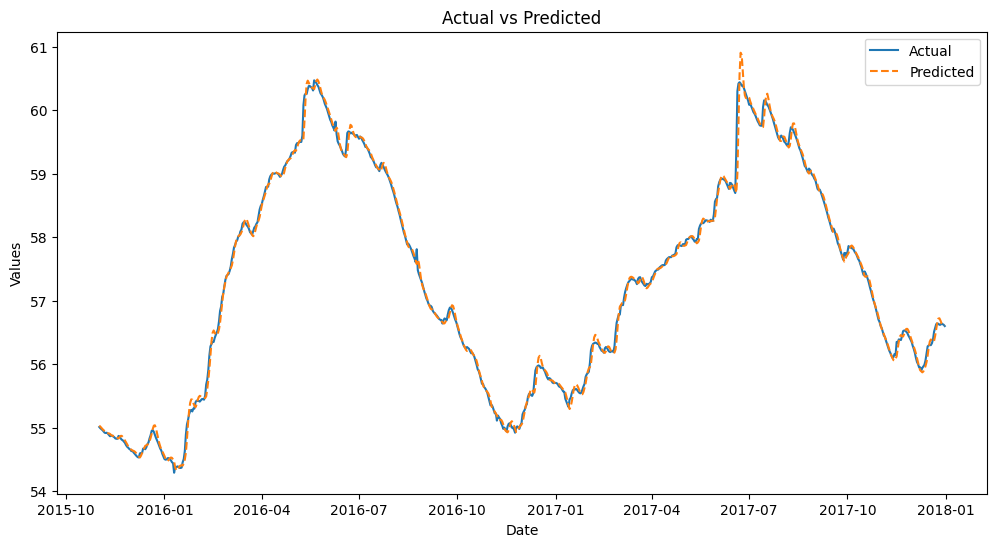

In [9]:
# Plot data aktual dan prediksi
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test_conv[0]):], y_test_conv[0], label='Actual')
plt.plot(df.index[-len(y_test_conv[0]):], predicted_conv[:,0], label='Predicted', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Dense, Flatten
from keras.callbacks import EarlyStopping

# Membaca dataset dari Excel
df = pd.read_excel(data)  # Ganti 'lokasi_file_data.xlsx' dengan lokasi file data yang sebenarnya

# Menetapkan kolom 'Bulan Tahun' sebagai indeks dan mengubahnya menjadi format tanggal
df.set_index('Bulan Tahun', inplace=True)
df.index = pd.to_datetime(df.index, format='%Y-%m')

# Melakukan scaling pada data untuk normalisasi
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Membagi data menjadi data latih dan data uji
train_size = int(len(df_scaled) * 0.6)
train, test = df_scaled[0:train_size, :], df_scaled[train_size:len(df_scaled), :]

# Fungsi untuk membuat dataset dengan timesteps tertentu
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps - 1):
        a = dataset[i:(i + time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

# Menyiapkan data untuk model ConvLSTM
time_steps = 84  # Menggunakan data 84 bulan sebelumnya untuk memprediksi bulan berikutnya
X_train_conv, y_train_conv = create_dataset(train, time_steps)
X_test_conv, y_test_conv = create_dataset(test, time_steps)

# Mengubah bentuk data untuk ConvLSTM
X_train_conv = X_train_conv.reshape((X_train_conv.shape[0], X_train_conv.shape[1], 1, 1, 1))
X_test_conv = X_test_conv.reshape((X_test_conv.shape[0], X_test_conv.shape[1], 1, 1, 1))

# Membangun dan melatih model ConvLSTM
model_conv = Sequential([
    ConvLSTM2D(32, (1, 1), activation='relu', input_shape=(time_steps, 1, 1, 1)),
    Flatten(),
    Dense(1)
])
model_conv.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_conv.fit(X_train_conv, y_train_conv, epochs=500, batch_size=32, verbose=1, validation_split=0.6, callbacks=[early_stop])
predicted_conv = model_conv.predict(X_test_conv)

# Menyiapkan data untuk model BPNN
X_train_bpnn, y_train_bpnn = create_dataset(train, time_steps)
X_test_bpnn, y_test_bpnn = create_dataset(test, time_steps)

# Membangun dan melatih model BPNN
model_bpnn = Sequential([
    Dense(64, activation='relu', input_dim=time_steps),
    Dense(32, activation='relu'),
    Dense(1)
])
model_bpnn.compile(optimizer='adam', loss='mean_squared_error')
model_bpnn.fit(X_train_bpnn, y_train_bpnn, epochs=500, batch_size=32, verbose=1, validation_split=0.6, callbacks=[early_stop])
predicted_bpnn = model_bpnn.predict(X_test_bpnn)

# Membalikkan scaling pada prediksi
predicted_conv = scaler.inverse_transform(predicted_conv)
predicted_bpnn = scaler.inverse_transform(predicted_bpnn)
y_test_conv = scaler.inverse_transform([y_test_conv])[0]  # Membalikkan scaling dan memilih array 1D

# Memperkuat model dengan Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, max_depth=5, min_samples_split=4, max_features='sqrt', random_state=42)
gb_model.fit(np.hstack((X_train_conv.reshape(X_train_conv.shape[0], -1), X_train_bpnn)), y_train_conv)
predicted_gb = gb_model.predict(np.hstack((X_test_conv.reshape(X_test_conv.shape[0], -1), X_test_bpnn)))
predicted_gb = scaler.inverse_transform(predicted_gb.reshape(-1, 1))

# Menggabungkan prediksi dari semua model untuk model meta
stacked_predictions = np.column_stack((predicted_conv, predicted_bpnn, predicted_gb))
# Melatih model meta dengan XGBoost
meta_model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.1)
meta_model_xgb.fit(stacked_predictions, y_test_conv)
final_predictions_xgb = meta_model_xgb.predict(stacked_predictions)

# Menghitung RMSE untuk masing-masing model
rmse_conv = np.sqrt(mean_squared_error(y_test_conv, predicted_conv))
rmse_bpnn = np.sqrt(mean_squared_error(y_test_conv, predicted_bpnn))
rmse_gb = np.sqrt(mean_squared_error(y_test_conv, predicted_gb))
rmse_xgb = np.sqrt(mean_squared_error(y_test_conv, final_predictions_xgb))

print(f"Root Mean Squared Error (ConvLSTM): {rmse_conv:.4f}")
print(f"Root Mean Squared Error (BPNN): {rmse_bpnn:.4f}")
print(f"Root Mean Squared Error (Gradient Boosting): {rmse_gb:.4f}")
print(f"Root Mean Squared Error (CLBGXGBoostS): {rmse_xgb:.4f}")

Epoch 1/500
16/16 [==============================] - 5s 152ms/step - loss: 0.4037 - val_loss: 0.3077
Epoch 2/500
16/16 [==============================] - 2s 98ms/step - loss: 0.2714 - val_loss: 0.1879
Epoch 3/500
16/16 [==============================] - 1s 73ms/step - loss: 0.1253 - val_loss: 0.0261
Epoch 4/500
16/16 [==============================] - 1s 76ms/step - loss: 0.0321 - val_loss: 0.0154
Epoch 5/500
16/16 [==============================] - 1s 79ms/step - loss: 0.0157 - val_loss: 0.0120
Epoch 6/500
16/16 [==============================] - 1s 83ms/step - loss: 0.0131 - val_loss: 0.0092
Epoch 7/500
16/16 [==============================] - 1s 82ms/step - loss: 0.0118 - val_loss: 0.0085
Epoch 8/500
16/16 [==============================] - 1s 74ms/step - loss: 0.0109 - val_loss: 0.0077
Epoch 9/500
16/16 [==============================] - 1s 69ms/step - loss: 0.0099 - val_loss: 0.0068
Epoch 10/500
16/16 [==============================] - 1s 75ms/step - loss: 0.0088 - val_loss: 0.006

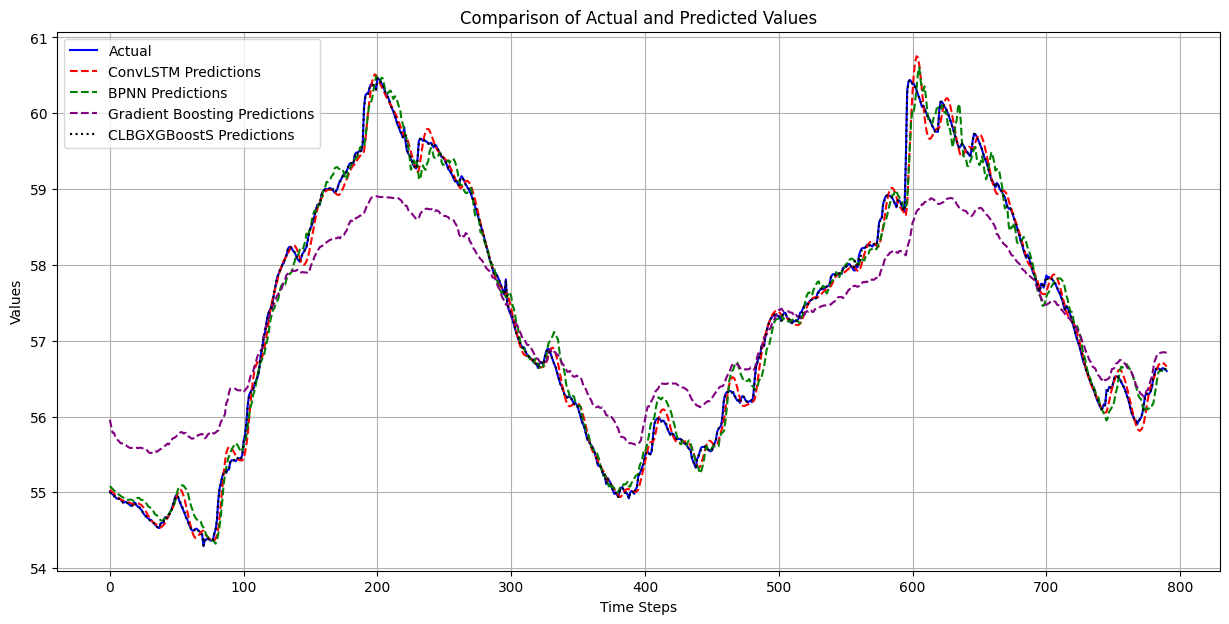

In [11]:
# Menghitung indeks berdasarkan panjang data y_test_conv
time_index = np.arange(len(y_test_conv.flatten()))

plt.figure(figsize=(15, 7))
plt.plot(time_index, y_test_conv.flatten(), label='Actual', color='blue')
plt.plot(time_index, predicted_conv.flatten(), label='ConvLSTM Predictions', linestyle='--', color='red')
plt.plot(time_index, predicted_bpnn.flatten(), label='BPNN Predictions', linestyle='--', color='green')
plt.plot(time_index, predicted_gb.flatten(), label='Gradient Boosting Predictions', linestyle='--', color='purple')
plt.plot(time_index, final_predictions_xgb, label='CLBGXGBoostS Predictions', linestyle=':', color='black')

plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()